## Integrate *gene expression* and *chromatin accessibility* using MultiVI

**Training:** *bone marrow, 70% of cells*\
**Testing:** *bone marrow, 30% of cells*\
**Grouping:** *cell type*

In [1]:
# Hide warnings generated in notebook.
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Import libraries.
import anndata as ad
import numpy as np
import pandas as pd
import random
import scanpy as sc
import scvi
import sklearn.neighbors as sk

from matplotlib import pyplot as plt

[rank: 0] Global seed set to 0


### *Define parameters for the MultiVI model and integrating modalities*

In [3]:
# Specify the MultiVI model name.
save_model = "bone-marrow.70-30_celltype"

# Percentage of cells used for the training data.
training_size = 0.7

# Variable to group by in the latent space.
grouping = "celltype"

# Create a list of colors for the group types.
colors = ["gray","purple","orange","pink","red","firebrick","springgreen","olive","forestgreen","cyan","blue","navy"]

### *Combine single-modalities into multiome data set*

In [4]:
# Load single-cell RNA and ATAC data.
bn_rna = scvi.data.read_h5ad("/fh/fast/setty_m/user/kfeldman/multi-modal_integration/data/bone-marrow_rna.h5ad")
bn_atac = scvi.data.read_h5ad("/fh/fast/setty_m/user/kfeldman/multi-modal_integration/data/bone-marrow_atac.h5ad")

# Save the raw gene expression counts.
bn_rna.layers["raw"] = bn_rna.raw.X.copy()

# Save the chromatin accessibility peaks in the same layer as raw gene expression counts.
bn_atac.layers["raw"] = bn_atac.X.copy()

# Concatenate the RNA genes and ATAC peaks and retain modality information.
bn_concat = ad.concat([bn_rna, bn_atac], axis=1, label="modality", keys=["Gene Expression","Peaks"])

# Add group type information from the gene expression data.
bn_concat.obs[grouping] = bn_rna.obs[grouping].copy()

### *Randomly divide data into training and testing subsets*

In [5]:
# Create list of indices based on number of cells.
index = list(range(0, bn_concat.n_obs))

# Randomly shuffle the indices.
random.shuffle(index)

# Determine the size of the training subset.
n = round(bn_concat.n_obs * training_size)

# Save the indices for each subset.
index_paired = index[:n]
index_unpaired = index[n:]

# Divide the data set into paired and unpaired subsets, and create copies of the unpaired subset with modalities removed.
bn_paired = bn_concat[index_paired].copy()
bn_rna = bn_concat[index_unpaired, bn_concat.var.modality == "Gene Expression"].copy()
bn_atac = bn_concat[index_unpaired, bn_concat.var.modality == "Peaks"].copy()

### *Organize and set up the AnnData object*

In [6]:
# Concatenate AnnData objects and add 0s to missing modalities.
bn_multiome = scvi.data.organize_multiome_anndatas(bn_paired, bn_rna, bn_atac)

# Ensure that the AnnData is ordered properly with genes before genomic regions.
bn_multiome = bn_multiome[:, bn_multiome.var["modality"].argsort()].copy()

In [7]:
# Set up AnnData object for training.
# OPTIONAL: Identify categorical and continuous covariates.
scvi.model.MULTIVI.setup_anndata(bn_multiome, batch_key="modality", layer="raw")

2023-05-30 20:24:26.750237: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### *Create and train MultiVI model*

In [8]:
# Create the MultiVI model by specifying how many genes and genomic regions.
# multiome_model = scvi.model.MULTIVI(
#     bn_multiome,
#     n_genes=(bn_multiome.var["modality"] == "Gene Expression").sum(),
#     n_regions=(bn_multiome.var["modality"] == "Peaks").sum(),
#     gene_likelihood="negative_binomial"
# )

In [9]:
# Train the MultiVI model.
# multiome_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 94/500:  19%|█▉        | 94/500 [41:54<3:01:00, 26.75s/it, loss=7.37e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 16382.854. Signaling Trainer to stop.


In [10]:
# Save the trained MultiVI model.
# multiome_model.save("/fh/fast/setty_m/user/kfeldman/multi-modal_integration/scvi-tools/models/" + save_model, overwrite=True)

In [8]:
# Load the trained MultiVI model.
multiome_model = scvi.model.MULTIVI.load("/fh/fast/setty_m/user/kfeldman/multi-modal_integration/scvi-tools/models/" + save_model, adata=bn_multiome)

INFO     File                                                                                                      
         /fh/fast/setty_m/user/kfeldman/multi-modal_integration/scvi-tools/models/bone-marrow.70-30_celltype/model.
         pt already downloaded                                                                                     


### *Visualize the latent space of the MultiVI model*

In [9]:
# Store the latent representation from the model in the AnnData object.
latent = multiome_model.get_latent_representation()
bn_multiome.obsm["X_MultiVI"] = latent

In [10]:
# Look at the shape of the latent space.
print(latent.shape)

(11215, 21)


In [11]:
# Use the MultiVI latent space to generate a UMAP.
sc.pp.neighbors(bn_multiome, use_rep="X_MultiVI")
sc.tl.umap(bn_multiome, min_dist=0.3)

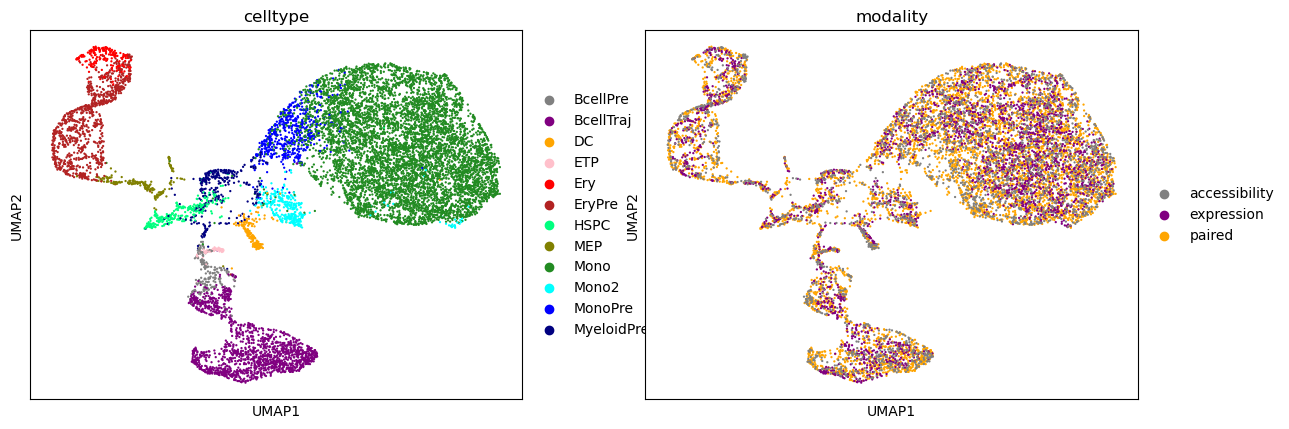

In [12]:
# Visualize UMAP of latent space.
sc.pl.umap(bn_multiome, color=[grouping,"modality"], palette=colors)

### *Integrating **gene expression** to **chromatin accessibility** using nearest neighbors*

In [13]:
# Save the latent space of the single-modal accessibility data.
neighbor_latent = bn_multiome.obsm["X_MultiVI"][(bn_multiome.obs["modality"] == "accessibility")]

# Determine the nearest neighbors using the single-modal accessibility data in the latent space.
nbrs = sk.NearestNeighbors(n_neighbors=neighbor_latent.shape[0]).fit(neighbor_latent)

# Create an indices matrix for the nearest neighbors.
indices = nbrs.kneighbors(bn_multiome.obsm["X_MultiVI"], return_distance=False)

# Filter the rows for single-modal gene expression data.
neighbor_matrix = indices[(bn_multiome.obs["modality"] == "expression")]

# Create a list of the group types for the gene expression cells.
groupings = bn_multiome.obs[grouping][(bn_multiome.obs["modality"] == "expression")]

#### *Plot the percentage of cells that are correctly matched by the number of neighbors*

In [14]:
# Identify the row indices for chromatin accessibility (matched by cell).
match_values = indices[bn_multiome.obs["modality"] == "accessibility"][:,0]

# Create a matrix of accessibility indices with repeating columns.
match_matrix = np.tile(match_values, (neighbor_latent.shape[0], 1)).transpose()

# Find the gene expression and chromatin accessibility matches.
neighbor_matches = (neighbor_matrix == match_matrix)

In [15]:
# Add the number of matches per column (i.e., number of nearest neighbors).
column_counts = sum(neighbor_matches)

# Add all of the matches that have been found up to a column and divide by the total number of cells.
percent_matched = np.cumsum(column_counts)/neighbor_matches.shape[0]

# Save a list for plotting.
total_matches_rna = [range(0, neighbor_latent.shape[0]), percent_matched]

(0.0, 2.0)

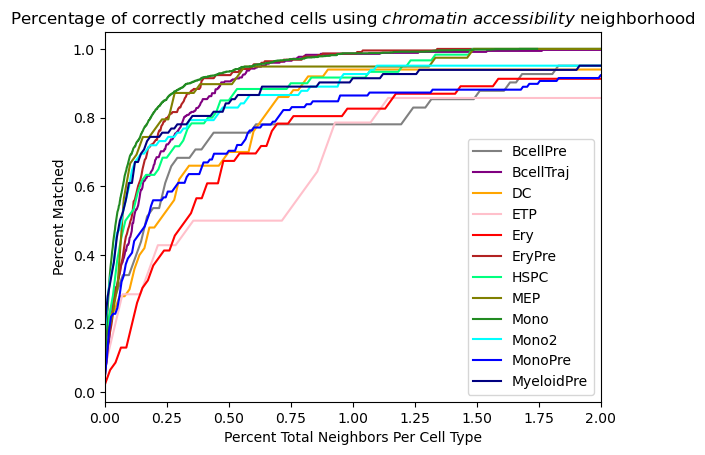

In [16]:
# Create empty list for filling with for loop.
group_matches_rna = []
num_cells = []

# Calculate the percentage of cells matched for each group type.
for group in np.unique(groupings):
    # Add the number of matches per column (i.e., number of nearest neighbors).
    column_counts = sum(neighbor_matches[(groupings == group),:])
    
    # Determine the number of cells for each cell type.
    num_cells.append(neighbor_matches[(groupings == group),:].shape[0])
    
    # Add all of the matches that have been found up to a column and divide by the total number of cells for that cell type.
    percent_matched = np.cumsum(column_counts)/neighbor_matches[(groupings == group),:].shape[0]
    
    group_matches_rna.append([group, range(0, neighbor_latent.shape[0]), percent_matched])

# Plot percent matched by normalized neighbors for each group type.
for i in range(0, len(colors)):
    plt.plot([x/num_cells[i] for x in group_matches_rna[i][1]], 
             group_matches_rna[i][2], label=group_matches_rna[i][0], c=colors[i])
    
# Add axis labels and title to plot.
plt.xlabel("Percent Total Neighbors Per Cell Type")
plt.ylabel("Percent Matched")
plt.title("Percentage of correctly matched cells using " + r"$\it{" + "chromatin\ accessibility" + "}$" + " neighborhood")

# Add a legend to the plot.
plt.legend()

# Define the number of neighbors to plot.
plt.xlim(0, 2)

#### *Plot the percentage of neighbors with the correct group type by the number of neighbors*

In [17]:
# Create an empty matrix to store group type strings in.        
group_matrix = np.empty([neighbor_matrix.shape[0], neighbor_matrix.shape[1]], dtype="S10")

# Create a list of accessibility group types.
neighbor_type = bn_multiome.obs[grouping][bn_multiome.obs["modality"] == "accessibility"]

# Based on the values in the neighbor matrix, store strings in the group type matrix.
for i in range(0, len(neighbor_type)):
    group_matrix[neighbor_matrix == i] = neighbor_type[i]

In [18]:
# Create empty list for filling with for loop.
correct_group_rna = []

# Calculate the percentage of neighbors that are the correct group type.
for group in np.unique(groupings):
    # Filter matrix by group type.
    filtered_matrix = group_matrix[(groupings == group),:]
    
    # Create a match matrix of the group type that is the same shape as the filtered matrix.
    match_matrix = np.full((filtered_matrix.shape[0], filtered_matrix.shape[1]), group, dtype="S10")
    
    # Add the number of matches per column (i.e., number of nearest neighbors).
    column_counts = sum(filtered_matrix == match_matrix)
    
    # Calculate the number of neighbors in the matrix.
    num_neighbors = [i * filtered_matrix.shape[0] for i in range(1, neighbor_latent.shape[0] + 1)]
    
    # Add all of the matches that have been found up to a column and divide by the total number of cells with that group type.
    percent_matched = np.cumsum(column_counts)/num_neighbors
    
    correct_group_rna.append([group, range(0, neighbor_latent.shape[0]), percent_matched])

### *Integrating **chromatin accessibility** to **gene expression** using nearest neighbors*

In [19]:
# Save the latent space of the single-modal expression data.
neighbor_latent = bn_multiome.obsm["X_MultiVI"][(bn_multiome.obs["modality"] == "expression")]

# Determine the nearest neighbors using the single-modal expression data in the latent space.
nbrs = sk.NearestNeighbors(n_neighbors=neighbor_latent.shape[0]).fit(neighbor_latent)

# Create an indices matrix for the nearest neighbors.
indices = nbrs.kneighbors(bn_multiome.obsm["X_MultiVI"], return_distance=False)

# Filter the rows for single-modal chromatin accessibility data.
neighbor_matrix = indices[(bn_multiome.obs["modality"] == "accessibility")]

# Create a list of the group types for the chromatin accessibility cells.
groupings = bn_multiome.obs[grouping][(bn_multiome.obs["modality"] == "accessibility")]

#### *Plot the percentage of cells that are correctly matched by the number of neighbors*

In [20]:
# Identify the row indices for gene expression (matched by cell).
match_values = indices[bn_multiome.obs["modality"] == "expression"][:,0]

# Create a matrix of expression indices with repeating columns.
match_matrix = np.tile(match_values, (neighbor_latent.shape[0], 1)).transpose()

# Find the gene expression and chromatin accessibility matches.
neighbor_matches = (neighbor_matrix == match_matrix)

In [21]:
# Add the number of matches per column (i.e., number of nearest neighbors).
column_counts = sum(neighbor_matches)

# Add all of the matches that have been found up to a column and divide by the total number of cells.
percent_matched = np.cumsum(column_counts)/neighbor_matches.shape[0]

# Save a list for plotting.
total_matches_atac = [range(0, neighbor_latent.shape[0]), percent_matched]

(0.0, 2.0)

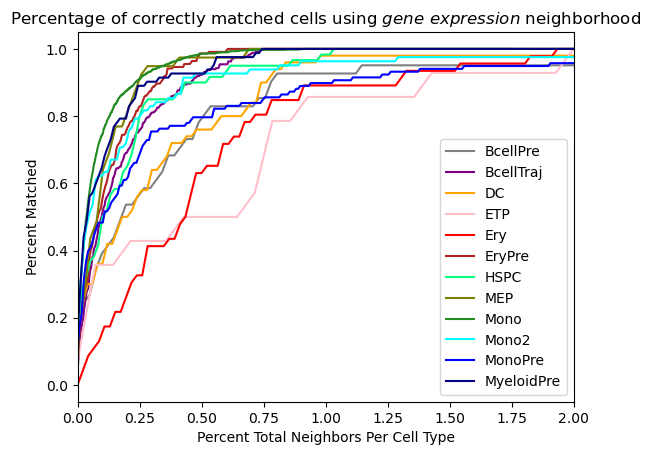

In [22]:
# Create empty list for filling with for loop.
group_matches_atac = []
num_cells = []

# Calculate the percentage of cells matched for each group type.
for group in np.unique(groupings):
    # Add the number of matches per column (i.e., number of nearest neighbors).
    column_counts = sum(neighbor_matches[(groupings == group),:])
    
    # Determine the number of cells for each cell type.
    num_cells.append(neighbor_matches[(groupings == group),:].shape[0])
    
    # Add all of the matches that have been found up to a column and divide by the total number of cells.
    percent_matched = np.cumsum(column_counts)/neighbor_matches[(groupings == group),:].shape[0]
    
    group_matches_atac.append([group, range(0, neighbor_latent.shape[0]), percent_matched])

# Plot percent matched by normalized neighbors for each group type.
for i in range(0, len(colors)):
    plt.plot([x/num_cells[i] for x in group_matches_atac[i][1]], 
             group_matches_atac[i][2], label=group_matches_atac[i][0], c=colors[i])
    
# Add axis labels and title to plot.
plt.xlabel("Percent Total Neighbors Per Cell Type")
plt.ylabel("Percent Matched")
plt.title("Percentage of correctly matched cells using " r"$\it{" + "gene\ expression" + "}$" + " neighborhood")

# Add a legend to the plot.
plt.legend()

# Define the number of neighbors to plot.
plt.xlim(0, 2)

#### *Plot the percentage of neighbors with the correct group type by the number of neighbors*

In [23]:
# Create an empty matrix to store group type strings in.        
group_matrix = np.empty([neighbor_matrix.shape[0], neighbor_matrix.shape[1]], dtype="S10")

# Create a list of expression group types.
neighbor_type = bn_multiome.obs[grouping][bn_multiome.obs["modality"] == "expression"]

# Based on the values in the neighbor matrix, store strings in the group type matrix.
for i in range(0, len(neighbor_type)):
    group_matrix[neighbor_matrix == i] = neighbor_type[i]

In [24]:
# Create empty list for filling with for loop.
correct_group_atac = []

# Calculate the percentage of neighbors that are the correct group type.
for group in np.unique(groupings):
    # Filter matrix by group type.
    filtered_matrix = group_matrix[(groupings == group),:]
    
    # Create a match matrix of the group type that is the same shape as the filtered matrix.
    match_matrix = np.full((filtered_matrix.shape[0], filtered_matrix.shape[1]), group, dtype="S10")
    
    # Add the number of matches per column (i.e., number of nearest neighbors).
    column_counts = sum(filtered_matrix == match_matrix)
    
    # Calculate the number of neighbors in the matrix.
    num_neighbors = [i * filtered_matrix.shape[0] for i in range(1, neighbor_latent.shape[0] + 1)]
    
    # Add all of the matches that have been found up to a column and divide by the total number of cells with that group type.
    percent_matched = np.cumsum(column_counts)/num_neighbors
    
    correct_group_atac.append([group, range(0, neighbor_latent.shape[0]), percent_matched])

### *Compare **gene expression** and **chromatin accessibility** integration ability*

#### *Plot the percentage of cells that are correctly matched by the number of neighbors*

(0.0, 1.0)

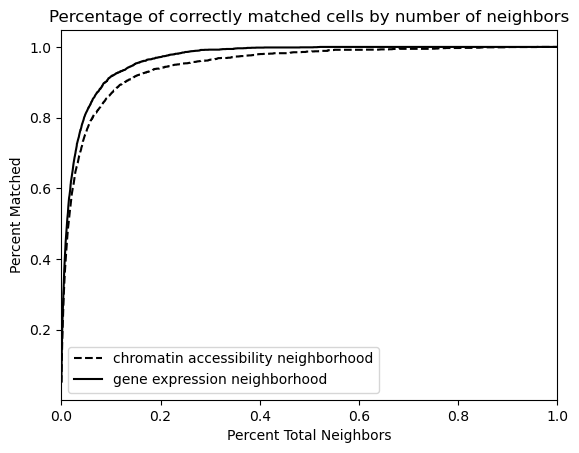

In [25]:
# Plot the percentage of matched cells by number of neighbors.
plt.plot([x/len(total_matches_rna[0]) for x in total_matches_rna[0]], total_matches_rna[1], label="chromatin accessibility neighborhood", c="black", linestyle="dashed")
plt.plot([x/len(total_matches_atac[0]) for x in total_matches_atac[0]], total_matches_atac[1], label="gene expression neighborhood", c="black")

# Add axis labels and title to plot.
plt.xlabel("Percent Total Neighbors")
plt.ylabel("Percent Matched")
plt.title("Percentage of correctly matched cells by number of neighbors")

# Add a legend to the plot.
plt.legend()

# Define the number of neighbors to plot.
plt.xlim(0, 1)

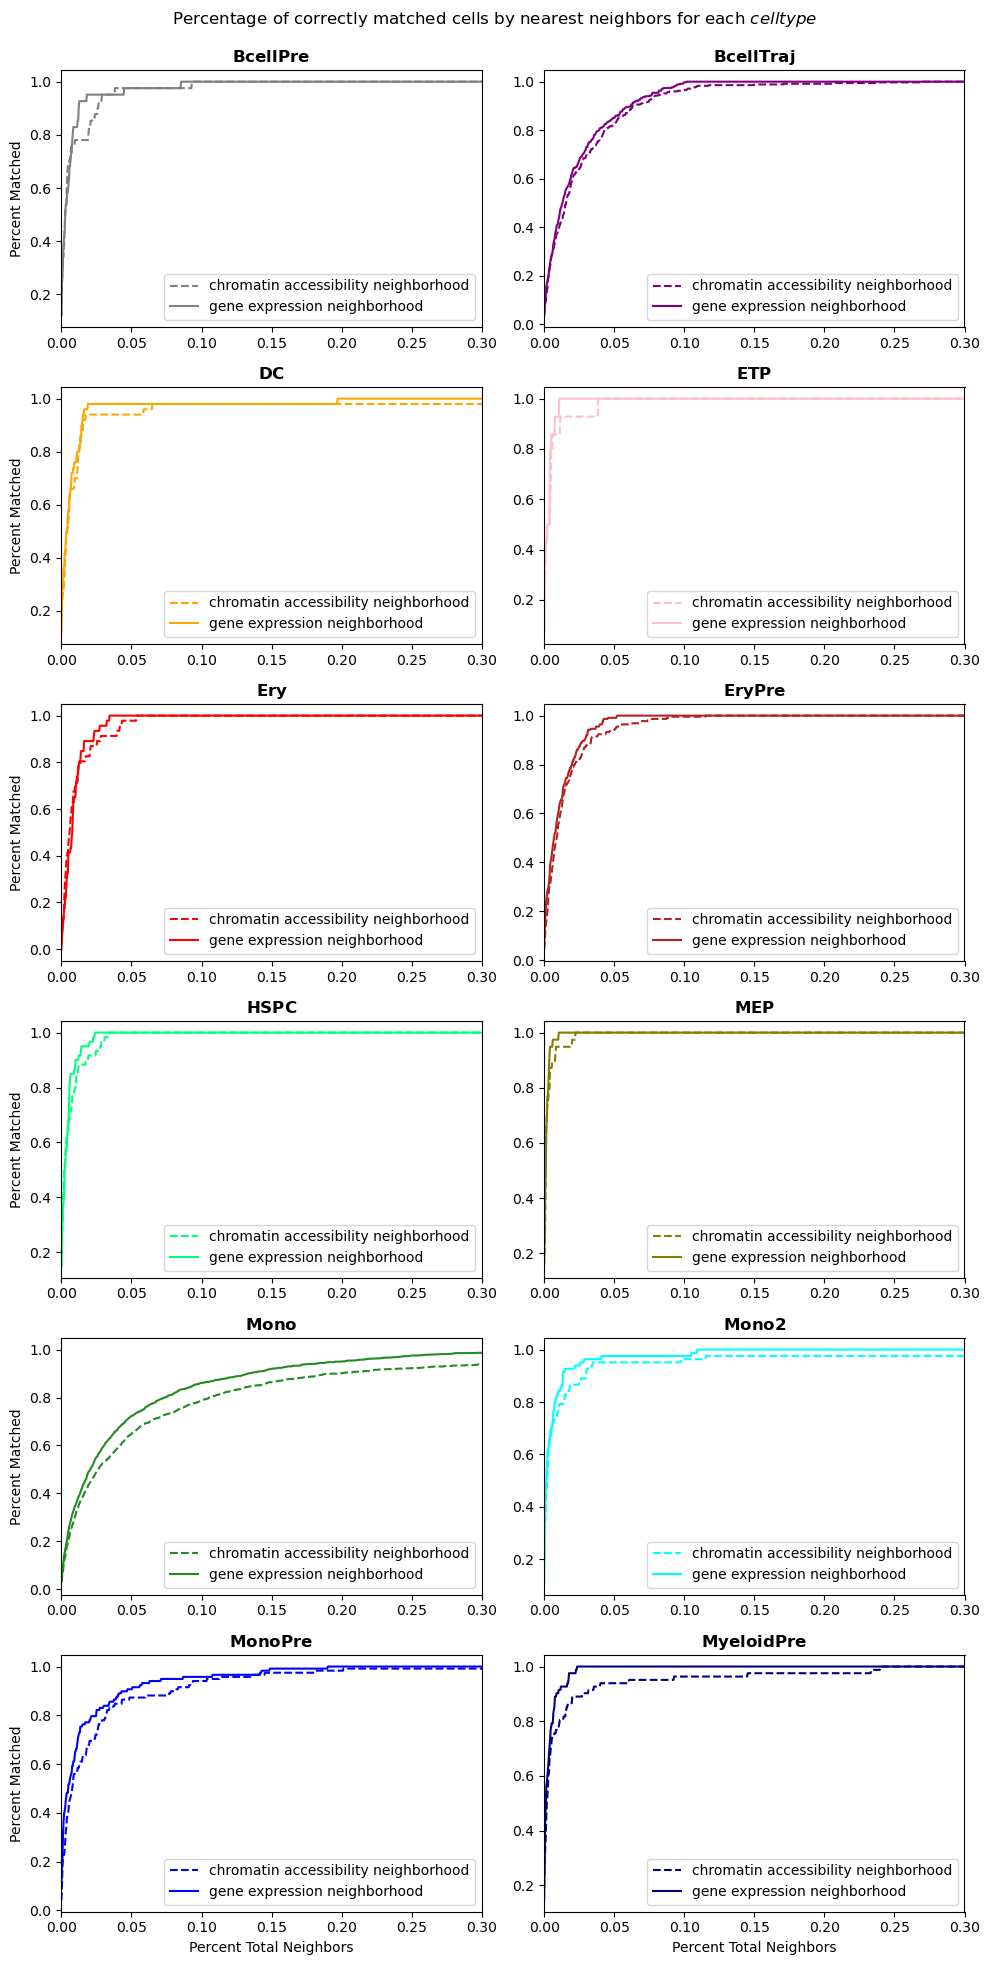

In [26]:
# Create a figure with subplots.
fig, axis = plt.subplots(6, 2, figsize=(10,20))

# Add title to figure.
fig.suptitle("Percentage of correctly matched cells by nearest neighbors for each " + r"$\it{" + str(grouping) + "}$")

# Create a list of subplot locations.
locations = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],[4,0],[4,1],[5,0],[5,1]]

# Plot the percentage of matched cells by number of neighbors for each group type.
for i in range(0, len(colors)):
    x, y = locations[i]
    
    axis[x, y].plot([x/len(group_matches_rna[i][1]) for x in group_matches_rna[i][1]], group_matches_rna[i][2], label="chromatin accessibility neighborhood", c=colors[i], linestyle="dashed")
    axis[x, y].plot([x/len(group_matches_atac[i][1]) for x in group_matches_atac[i][1]], group_matches_atac[i][2], label="gene expression neighborhood", c=colors[i])
    
    # Add the group type as a title for each subplot.
    axis[x, y].set_title(r"$\bf{" + str(group_matches_rna[i][0]) + "}$")
    
    # Add a legend to each subplot.
    axis[x, y].legend(loc="lower right")
    
    # Set the x-axis limit for each subplot.
    axis[x, y].set_xlim(0, 0.3)
    
    # Only plot labels for the x-axis on the bottom plots.
    if x == 5:
        axis[x, y].set_xlabel("Percent Total Neighbors")
        
    # Only plot labels for the y-axis on the left plots.
    if y == 0:
        axis[x, y].set_ylabel("Percent Matched")

# Close the distance between the plot title and subplots.
fig.tight_layout()
fig.subplots_adjust(top=0.95)

#### *Plot the percentage of neighbors with the correct group type by the number of neighbors*

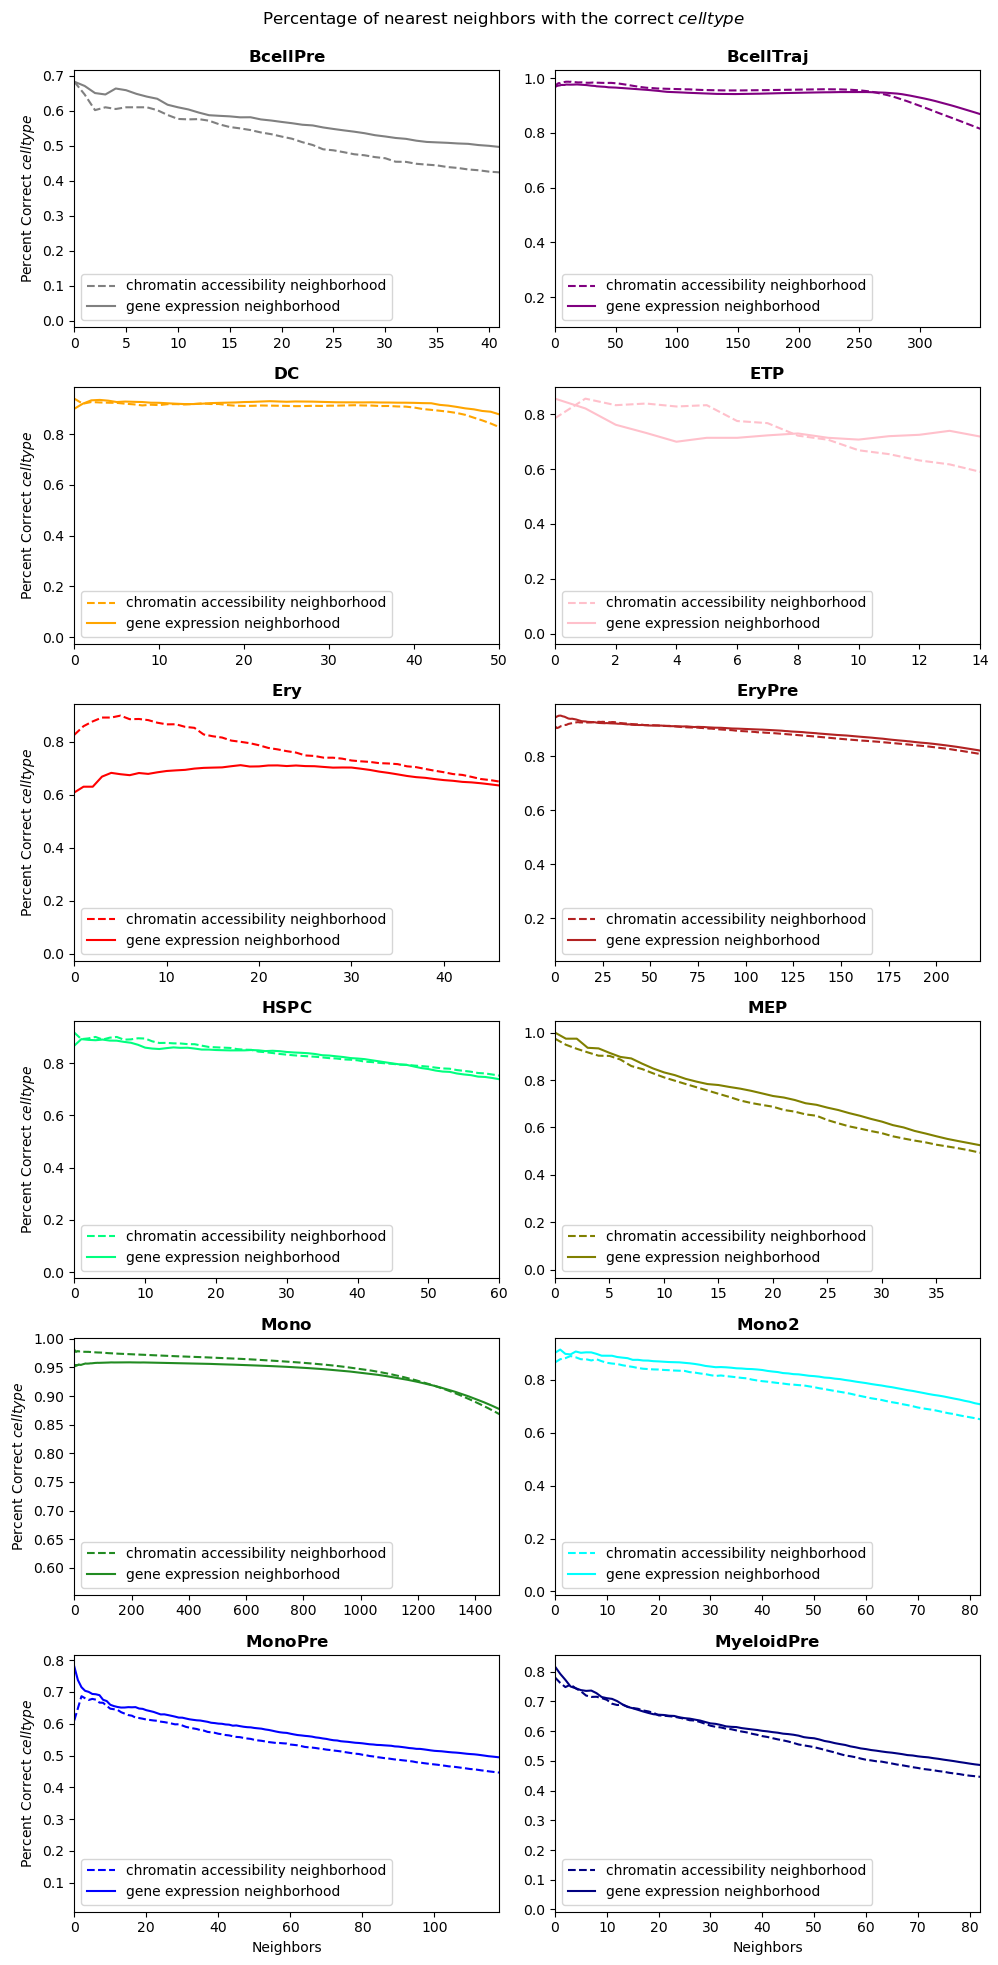

In [27]:
# Create a figure with subplots.
fig, axis = plt.subplots(6, 2, figsize=(10,20))

# Add title to figure.
fig.suptitle("Percentage of nearest neighbors with the correct " + r"$\it{" + str(grouping) + "}$")

# Create a list of subplot locations.
locations = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],[4,0],[4,1],[5,0],[5,1]]

# Plot the percentage of neighbors that are the correct group type.
for i in range(0, len(colors)):
    x, y = locations[i]
    
    axis[x, y].plot(correct_group_rna[i][1], correct_group_rna[i][2], label="chromatin accessibility neighborhood", c=colors[i], linestyle="dashed")
    axis[x, y].plot(correct_group_atac[i][1], correct_group_atac[i][2], label="gene expression neighborhood", c=colors[i])
    
    # Add the group type as a title for each subplot.
    axis[x, y].set_title(r"$\bf{" + str(correct_group_rna[i][0]) + "}$")
    
    # Add a legend to each subplot.
    axis[x, y].legend(loc="lower left")
    
    # Set the x-axis limits to the number of cells with that group type in the single-modal data for each subplot.
    neighbor_type = bn_multiome.obs[grouping][bn_multiome.obs["modality"] == "expression"]
    axis[x, y].set_xlim(0, sum(neighbor_type == correct_group_rna[i][0]))
    
    # Only plot labels for the x-axis on the bottom plots.
    if x == 5:
        axis[x, y].set_xlabel("Neighbors")
        
    # Only plot labels for the y-axis on the left plots.
    if y == 0:
        axis[x, y].set_ylabel("Percent Correct " + r"$\it{" + str(grouping) + "}$")

# Close the distance between the plot title and subplots.
fig.tight_layout()
fig.subplots_adjust(top=0.95)